# Multiple Hypothesis t-Test and Bonferroni Correction 

**Summary**: This notebook illustrates a multiple hypothesis testing, familywise error rates and the application of Bonferroni correction.

In [1]:
# imports 
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from scipy.stats import t
import stat_tests

# I. Simulating a Dataset from Random Samples

In [2]:
# generate two datasets for 100 variables, and each dataset comes from a different population.
# this mimics the HCP dataset wherein we have one population of males and another population of females.
# for each population, we gather a random sample and collect region-wise BOLD signal data to calculate the correlation between all possible pairs of reigons.

# We are interested in whether there is a difference between the male and female brain.
# To do so, we perform a t-test on each pairwise correlation value, testing whether the population means of each pairwise region are different in males and females.

# For simplicity's sake, each of the simulated 4950 pairwise correlations for male subjects will come from a normal distribution centered at 5, 
# while for female subjects, they come from a normal distribution centered at -5.

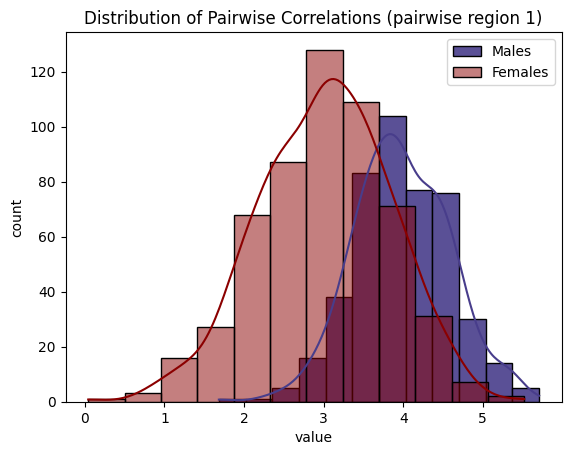

In [3]:
# male distribution of correlation values
n_males = 550 # arbitrary sample size
m_males = 3 # center
sd_males = 0.8 # arbitrary spread

# population 2
n_females = 450 # arbitrary sample size
m_females = 4 # center
sd_females = 0.6 # arbitrary spread

# generate two sets of simulated pairwise correlations from a normal distribution with the respective parameters
num_correlations = 4950
np.random.seed(1234)
m_netmats = np.random.normal(loc=m_males, scale=sd_males, size=(n_males, num_correlations))
f_netmats = np.random.normal(loc=m_females, scale=sd_females, size=(n_females, num_correlations))

# get distribution of pairwise correlation at i=0
pairwise_region = 0
m_corr = m_netmats[:, pairwise_region]
f_corr = f_netmats[:, pairwise_region]

# plot the two samples
bins = 12
ax = sns.histplot(f_corr, kde=True, bins=bins, label="Males", alpha=0.9, color="darkslateblue")
ax = sns.histplot(m_corr, kde=True, bins=bins, label="Females", alpha=0.5, color="darkred")
ax.set(xlabel='value', ylabel='count', title='Distribution of Pairwise Correlations (pairwise region 1)')
plt.legend()
plt.show()

# II. Calculating the $t$-Statistics and p-values

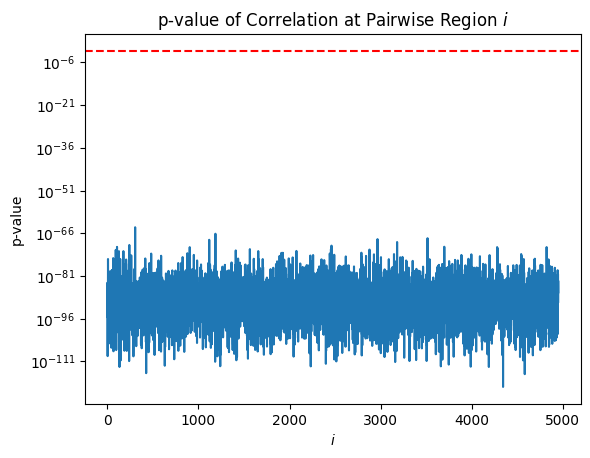

In [4]:
alpha = 0.01

# calculate the t-statistic and p-values for each pairwise correlation value 
t_stats, mf_sqse, pvals = stat_tests.get_tstats(f_netmats, m_netmats)

# plot p-values
plt.plot(pvals)
plt.axhline(y=alpha, color='r', linestyle='--')

plt.title('p-value of Correlation at Pairwise Region $i$')
plt.xlabel('$i$')
plt.ylabel('p-value')
plt.yscale('log')

As we can see, the t-test yielded a p-value < $\alpha$ for all of the pairwise correlations. This is because of the minimally overlapping male and female distributions. 

However, when working with a real-life dataset, the distributions may be less distinct. We can repeat this simulation, but with two distributions that have the same population mean to demonstrate the $t$-tests' performances on distributions with less distinct means.

## III. Checking Error Rate

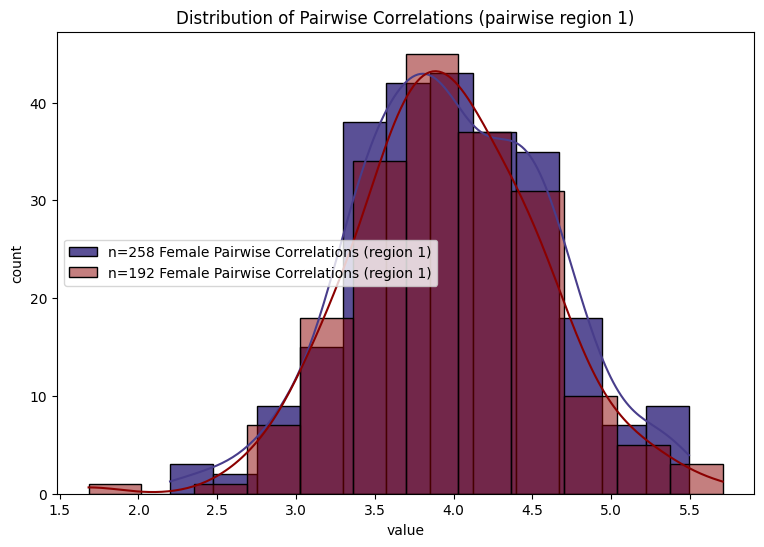

In [9]:
# calculate the t-statistic for each pairwise correlation value 
np.random.seed(28)
null_split = np.random.randint(n_females) + 1
null1 = f_netmats[:null_split]
null2 = f_netmats[null_split:]

# get distribution of pairwise correlation at i=0
pairwise_region = 0
null1_corr = null1[:, pairwise_region]
null2_corr = null2[:, pairwise_region]

# plot the two samples
bins = 12
fig, ax = plt.subplots(figsize=(9, 6))

sns.histplot(null1_corr, kde=True, bins=bins, label=f"n={null_split} Female Pairwise Correlations (region 1)", alpha=0.9, color="darkslateblue", ax=ax)
sns.histplot(null2_corr, kde=True, bins=bins, label=f"n={n_females - null_split} Female Pairwise Correlations (region 1)", alpha=0.5, color="darkred", ax=ax)
ax.set(xlabel='value', ylabel='count', title='Distribution of Pairwise Correlations (pairwise region 1)')
plt.legend()
plt.show()

C:\Users\dfabe\AppData\Local\Temp\ipykernel_38536\729928660.py:19: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0, alpha+0.01)


(1.2334857251476547e-05, 0.02)

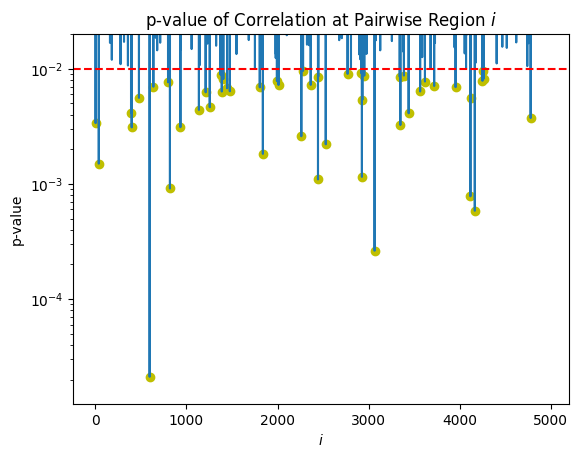

In [6]:
# calculate the t-statistic and p-values for each pairwise correlation value 
_, _, null_pvals = stat_tests.get_tstats(null1, null2)

# plot p-values
plt.plot(null_pvals)
plt.axhline(y=alpha, color='r', linestyle='--')

plt.title('p-value of Correlation at Pairwise Region $i$')
plt.xlabel('$i$')
plt.ylabel('p-value')
plt.yscale('log')


# highlight p-vals less than alpha
fp_ix = np.where(null_pvals < alpha)[0]
fp = null_pvals[fp_ix]
plt.scatter(x=fp_ix, y=fp, color='y')

plt.ylim(0, alpha+0.01)

When comparing the difference of means for 4950 simulated pairwise correlations that are sampled from a the same normal distribution, we see that their respective $t$-statistics yield p-values less than $\alpha$. In other words, the two-sided independent samples $t$-test yields false positives.

In [7]:
print(f"The two-sided independent samples t-test (alpha={alpha}) yielded {len(fp)} false positives (rate={len(fp) / num_correlations})).")

The two-sided independent samples t-test (alpha=0.01) yielded 49 false positives (rate=0.009898989898989899)).


The false positive rate is approximately equal to $\alpha=0.01$, as expected. However, for our exploratory data analysis, we are interested in conducting a more conservative statistical test.

# IV. Applying Bonferroni Correction

When performing a statistical test, the significance level ($\alpha$) is defined as the probability of incorrectly rejecting the null hypothesis. The significance level can be interpreted as the amount of evidence we must observe in order to reject the null hypothesis and declare statistically significant results.  

When considering multiple hypothesis testing, the probability of incorrectly rejecting the null hypothesis, also referred to as false positive rate, is equal to $\alpha$ for *each* hypothesis. The *total* false positive rate, however, is also dependent on $n$, or the number of hypotheses:

$$
P_{FWER} = 1 - (1 - \alpha)^n
$$

This is recognized as the Familywise Error Rate ($FWER$), or the probablity of at least one false positive. Using this formula, our multiple hypotheses test has a probability of incorrectly rejecting the null hypothesis once ($FWER$) of almost 1. The Bonferroni correction is a correction that change the $\alpha$ to reduce the Family Wise Error rate.  

Bonferroni-corrected $\alpha$:
$$
\frac{\alpha}{n}
$$ 

Plugging in the Bonferroni-corrected $\alpha$ into the Familywise Error Rate equation, assuming that $n$ is large and $\alpha$ is small, our new total probability of incorrecting the null hypothesis is approximately equal to $\alpha$:

$$
P_{FWER} = 1 - (1 - \frac{\alpha}{n})^n \\
\approx \alpha
$$

We can apply this Bonferroni correction to the alpha for our simulated-data $t$-test:

C:\Users\dfabe\AppData\Local\Temp\ipykernel_38536\1253651627.py:18: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0, bonferroni_alpha+0.01)


(1.0487549686798315e-06, 0.010002020202020203)

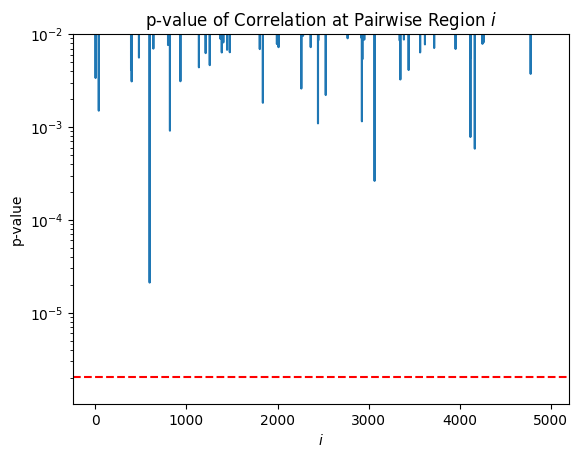

In [8]:
bonferroni_alpha = alpha / num_correlations # Bonferroni correction

# plot p-values
plt.plot(null_pvals)
plt.title('p-value of Correlation at Pairwise Region $i$')
plt.xlabel('$i$')
plt.ylabel('p-value')
plt.yscale('log')

# highlight p-vals less than alpha
plt.axhline(y=bonferroni_alpha, color='r', linestyle='--')
bonferroni_fp_ix = np.where(null_pvals < bonferroni_alpha)[0]
bonferroni_fp = null_pvals[bonferroni_fp_ix]

plt.scatter(x=bonferroni_fp_ix, y=bonferroni_fp, color='y')


plt.ylim(0, bonferroni_alpha+0.01)

As we can see, our new total false positive rate is much lower, yielding zero false positives.